# **Prepare data**

In [202]:
import pandas as pd
import datetime as dt

In [203]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
# Load the transactional data
transactions_df = pd.read_csv("/content/drive/MyDrive/DA20 - Final Project/Unsupervised Learning/customer-transactions.csv")
items_df = pd.read_csv("/content/drive/MyDrive/DA20 - Final Project/Unsupervised Learning/items.csv")

print(transactions_df.head())
print(items_df.head())

   OrderID  CustomerID  ItemID TransactionDate   Channel
0        0           0     352      2020-03-21  In Store
1        0           0    3433      2020-07-14  In Store
2        0           0   11162      2020-08-09  In Store
3        0           0   13011      2020-12-07  In Store
4        0           0   13885      2020-11-08  In Store
   ItemID                     Product             Brand  SellPrice  CostPrice
0       1  032irview0.686128260621012  Ki)D3jDmA,RIP68X        943        359
1       2  070ttream0.518887735674677  GO4582ey<S!+k1VE        717        207
2       3  070htream0.333307794468401  G.Kb^jz*soY!(-4Q        739        199
3       4  100Grseys0.271522111052549  Dr|vm[-5p~56Y\mk        532        262
4       5  100[nside0.645837365801341  Dr|vm[-5p~56Y\mk        593        392


In [205]:
print(transactions_df.isnull().sum())
print(items_df.isnull().sum())

OrderID            0
CustomerID         0
ItemID             0
TransactionDate    0
Channel            0
dtype: int64
ItemID       0
Product      0
Brand        0
SellPrice    0
CostPrice    0
dtype: int64


In [206]:
# Identify duplicate rows
print(f'Number of duplicates (transactions_df): {transactions_df.duplicated().sum()}')
print(f'Number of duplicates (items_df): {items_df.duplicated().sum()}')

Number of duplicates (transactions_df): 0
Number of duplicates (items_df): 0


In [207]:
# Perform a left join on the ItemID column to add the SellPrice column to the transactions_df
transactions_df = pd.merge(transactions_df, items_df[['ItemID', 'SellPrice']], on='ItemID', how='left')

# Print the updated transactions dataframe
print(transactions_df.head())


   OrderID  CustomerID  ItemID TransactionDate   Channel  SellPrice
0        0           0     352      2020-03-21  In Store        735
1        0           0    3433      2020-07-14  In Store        963
2        0           0   11162      2020-08-09  In Store        582
3        0           0   13011      2020-12-07  In Store        339
4        0           0   13885      2020-11-08  In Store       1369


# **Calculate RFM Score**

In [208]:
# Convert the TransactionDate column to a datetime object
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Calculate the Recency, Frequency, and Monetary values for each customer
recency_df = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency_df['Recency'] = (dt.datetime.today() - recency_df['TransactionDate']).dt.days
recency_df.drop('TransactionDate', axis=1, inplace=True)

frequency_df = transactions_df.groupby('CustomerID')['OrderID'].nunique().reset_index()
frequency_df.rename(columns={'OrderID': 'Frequency'}, inplace=True)


monetary_df = transactions_df.groupby('CustomerID')['SellPrice'].sum().reset_index()
monetary_df.rename(columns={'SellPrice': 'Monetary'}, inplace=True)

# Merge the Recency, Frequency, and Monetary dataframes
rfm_df = pd.merge(recency_df, frequency_df, on='CustomerID')
rfm_df = pd.merge(rfm_df, monetary_df, on='CustomerID')



rfm_df.drop(columns=['CustomerID'], inplace=True)

# Print the RFM dataframe
print(rfm_df.head())

   Recency  Frequency  Monetary
0      862         15     32997
1      870         14     34948
2      874          7     17879
3      865          6     14603
4      863         14     37029


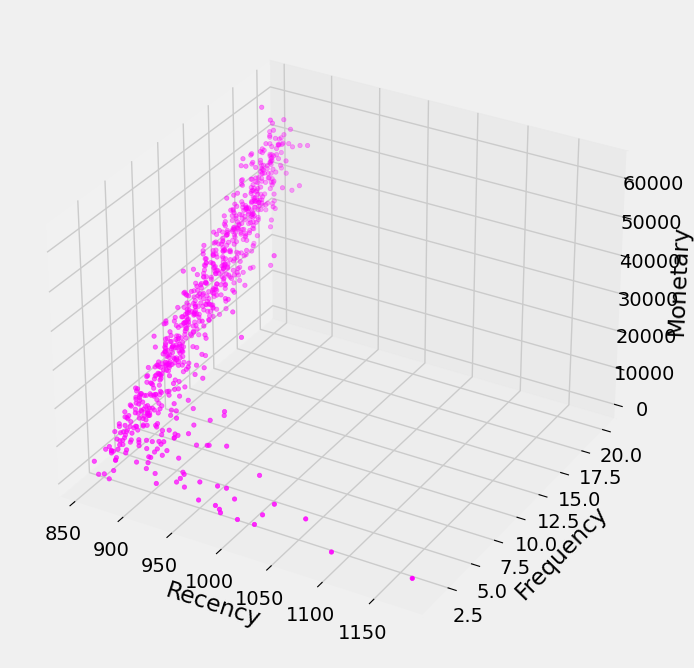

In [209]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

x = rfm_df['Recency']
y = rfm_df['Frequency']
z = rfm_df['Monetary']

ax.scatter(x, y, z, c='magenta' ,s=10)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()


# **Scale Data**

In [210]:
X = rfm_df.iloc[:].values
X

array([[  862,    15, 32997],
       [  870,    14, 34948],
       [  874,     7, 17879],
       ...,
       [  859,    19, 45470],
       [  858,    15, 35462],
       [  863,    10, 24568]])

In [211]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# **Evaluate**

In [212]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [213]:
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

**Sum of Squared Errors (SSE)**

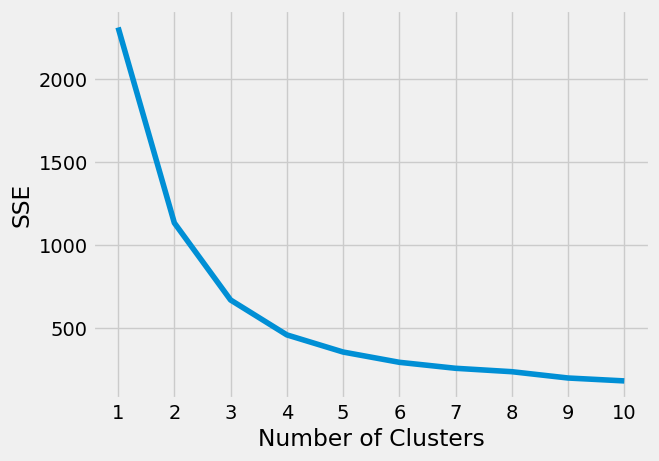

In [214]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
 kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
 kmeans.fit(scaled_features)
 sse.append(kmeans.inertia_)



plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [215]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

print(f'Elbow: {kl.elbow}')

Elbow: 3


**Sillhouette**

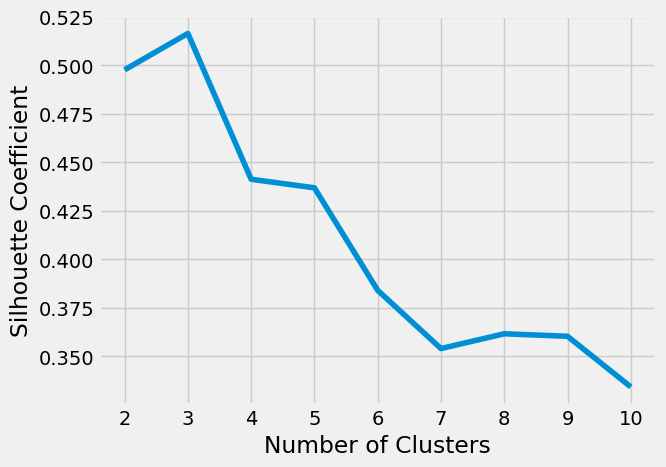

In [216]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
 kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
 kmeans.fit(scaled_features)
 score = silhouette_score(scaled_features, kmeans.labels_)
 silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [223]:
import numpy as np

# Find the index of the maximum silhouette score
best_idx = np.argmax(silhouette_coefficients)

# The best number of clusters is the index plus 2 (because we started at 2 clusters)
best_n_clusters = best_idx + 2

print(f"The best number of clusters is {best_n_clusters}")


The best number of clusters is 3


# **Model (K-Mean Clustering)**

In [224]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [225]:
import plotly.express as px

# Create a DataFrame with the RFM scores and cluster labels
df = pd.DataFrame(X, columns=['Recency', 'Frequency', 'Monetary'])
df['Cluster'] = y_kmeans
df['Cluster'] = df['Cluster'].astype('str')

# Create the plot
fig = px.scatter_3d(df, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', opacity=0.8, size_max=1, height=1000)

fig.show()

